# 한국전력거래소_발전원별 발전량(계통기준) (5분 단위, 15분전)

In [1]:
import cx_Oracle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
from matplotlib import font_manager,rc
import numpy as np
import seaborn as sns


In [2]:
font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)

* 기초통계정보 확인

-- 전일의 데이터를 csv로 만들어 가져오기

In [90]:
df = pd.read_csv('data_test.csv')

-- 오라클에서 데이터 가져오기

In [12]:
conn = cx_Oracle.connect('open_source/1111@192.168.0.18:1521/xe')
cur = conn.cursor()

In [13]:
collect_sql= "select * from power_amounts order by baseDatetime"
cur.execute(collect_sql)
df = pd.DataFrame(cur)


In [14]:
df.shape

(106, 11)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       106 non-null    datetime64[ns]
 1   1       106 non-null    float64       
 2   2       106 non-null    float64       
 3   3       106 non-null    float64       
 4   4       106 non-null    float64       
 5   5       106 non-null    float64       
 6   6       106 non-null    float64       
 7   7       106 non-null    float64       
 8   8       106 non-null    float64       
 9   9       106 non-null    float64       
 10  10      106 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 9.2 KB


In [16]:
# 데이터베이스에서 가져올 때 사용

In [17]:
df = df.rename(columns={0:'baseDatetime',1: '수력', 2: '유류',3:'유연탄',4:'원자력',5:'양수',6:'가스',7:'국내탄',8:'신재생',9:'태양광',10:'합계'})

In [ ]:
# 밑은 csv파일을 가져왔을 때 사용

In [ ]:
# df = df.rename(columns={'fuelPwr1': '수력', 'fuelPwr2': '유류','fuelPwr3':'유연탄','fuelPwr4':'원자력','fuelPwr5':'양수','fuelPwr6':'가스','fuelPwr7':'국내탄','fuelPwr8':'신재생','fuelPwr9':'태양광','fuelPwrTot':'합계'})

In [18]:
df.head()

,baseDatetime,수력,유류,유연탄,원자력,양수,가스,국내탄,신재생,태양광,합계
0,2024-08-05 00:00:00,355.247,368.216,25380.2,18925.4,452.571,18185.4,185.697,3408.86,0.0,67274.6
1,2024-08-05 00:05:00,357.865,368.887,25327.1,18943.8,449.418,17937.2,186.521,3408.78,0.0,66992.6
2,2024-08-05 00:10:00,357.907,369.719,25101.4,18927.3,445.459,17573.1,186.539,3409.13,0.0,66384.1
3,2024-08-05 00:15:00,357.130,369.818,25248.2,18947.5,435.234,17255.2,185.605,3399.46,0.0,66212.1
4,2024-08-05 00:20:00,355.744,369.521,24804.9,18953.0,433.098,17073.0,186.301,3386.75,0.0,65576.0


날짜 열의 포맷을 바꿔 알아보기 쉽게 하고, 시간을 활용할 것이기 때문에 따로 추출하여 인덱스로 만들었다.

In [19]:
# df['baseDatetime'] = pd.to_datetime(df['baseDatetime'], format='%Y%m%d%H%M%S') - 테이블 포맷이 timestamp라면 안 해도 됨.
df['시간'] = df['baseDatetime'].dt.hour
# df['baseDatetime'] = df['baseDatetime'].dt.strftime('%Y-%m-%d %H:%M')
df.head()

,baseDatetime,수력,유류,유연탄,원자력,양수,가스,국내탄,신재생,태양광,합계,시간
0,2024-08-05 00:00:00,355.247,368.216,25380.2,18925.4,452.571,18185.4,185.697,3408.86,0.0,67274.6,0
1,2024-08-05 00:05:00,357.865,368.887,25327.1,18943.8,449.418,17937.2,186.521,3408.78,0.0,66992.6,0
2,2024-08-05 00:10:00,357.907,369.719,25101.4,18927.3,445.459,17573.1,186.539,3409.13,0.0,66384.1,0
3,2024-08-05 00:15:00,357.130,369.818,25248.2,18947.5,435.234,17255.2,185.605,3399.46,0.0,66212.1,0
4,2024-08-05 00:20:00,355.744,369.521,24804.9,18953.0,433.098,17073.0,186.301,3386.75,0.0,65576.0,0


In [20]:
df = df.sort_values(by='baseDatetime')
df = df.set_index('시간') # 파이차트 용 인덱스
# df.set_index('baseDatetime', inplace=True) #바 차트 용 인덱스

fuelPwr1 : 수력, fuelPwr2 : 유류, fuelPwr3:유연탄, fuelPwr4 : 원자력, fuelPwr5 : 양수, fuelPwr6: 가스, fuelPwr7:국내탄, fuelPwr8 : 신재생, fuelPwr9:태양광
fuelPwrTot : 합계
baseDatetime : YYYY/MM/DD/HH/mm/초(초는 사용되지 않는다.)

### 2. 데이터 정제

#### 2.1. 원본데이터에서 분석가능한 형태로 데이터 전처리 (형변환, 열이름 변경등)
#### 2.2. 데이터 클리닝: 이상치, 결측치처리

### 3. 초기데이터 분석

#### 3.1 데이터 정제후 데이터딕셔너리 재확인
#### 3.2 기초통계 정보 확인 (최대값, 최소값, 평균값, 표준편차, 최빈값, 유일값 등)
#### 3.3 시각화를 통한 데이터이해 심화 

In [114]:
round(df.describe(),2)

,baseDatetime,수력,유류,유연탄,원자력,양수,가스,국내탄,신재생,태양광,합계
count,184,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.00
mean,2024-08-02 07:37:30,454.66,375.75,24466.99,18956.88,-1143.35,20044.12,379.22,3447.05,1888.01,68873.23
min,2024-08-02 00:00:00,294.05,367.14,22877.30,18900.50,-2737.28,10890.20,375.88,2604.00,0.00,58619.90
25%,2024-08-02 03:48:45,366.03,368.80,23827.90,18942.70,-2085.44,12926.82,378.31,2989.19,0.00,60970.92
50%,2024-08-02 07:37:30,416.70,370.13,24476.90,18958.05,-953.43,17803.70,379.33,3603.78,1056.12,67339.40
75%,2024-08-02 11:26:15,511.76,374.34,25164.80,18973.32,-428.08,27903.75,380.12,3873.25,4111.48,76700.58
max,2024-08-02 15:15:00,749.09,411.63,25968.60,19006.00,490.20,30794.70,382.85,3998.35,5154.32,80395.90
std,NaN,124.26,11.61,845.16,22.68,940.23,7167.08,1.38,473.43,1983.23,7843.35


* 3.3.1 단일 열: 데이터의 성격에 따른 다양한 차트 적용  
* 3.3.2 복수 열: 두개의 열간 연관관계 분석(Pair Plot 또는 Seaborn의 관련 지원 차트등)

* 최대값, 최소값, 평균값, 표준편차, 최빈값, 유일값, 결측치, 이상치 등의 정보를 재확인해 보세요

In [125]:
round(df.describe(),2)

,수력,유류,유연탄,원자력,양수,가스,국내탄,신재생,태양광,합계,시간
count,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.00,184.00
mean,454.66,375.75,24466.99,18956.88,-1143.35,20044.12,379.22,3447.05,1888.01,68873.23,7.17
std,124.26,11.61,845.16,22.68,940.23,7167.08,1.38,473.43,1983.23,7843.35,4.44
min,294.05,367.14,22877.30,18900.50,-2737.28,10890.20,375.88,2604.00,0.00,58619.90,0.00
25%,366.03,368.80,23827.90,18942.70,-2085.44,12926.82,378.31,2989.19,0.00,60970.92,3.00
50%,416.70,370.13,24476.90,18958.05,-953.43,17803.70,379.33,3603.78,1056.12,67339.40,7.00
75%,511.76,374.34,25164.80,18973.32,-428.08,27903.75,380.12,3873.25,4111.48,76700.58,11.00
max,749.09,411.63,25968.60,19006.00,490.20,30794.70,382.85,3998.35,5154.32,80395.90,15.00


* 데이터의 성격에 따라 이해도를 올리기 위해 시각화가 필요한 데이터차트를 만들어 보세요.  
  (Seaborn 추천: 페어플롯, 막대차트, 파이차트, 라인차트, 히스토그램등..)
* 시각화한 차트에 대한 분석

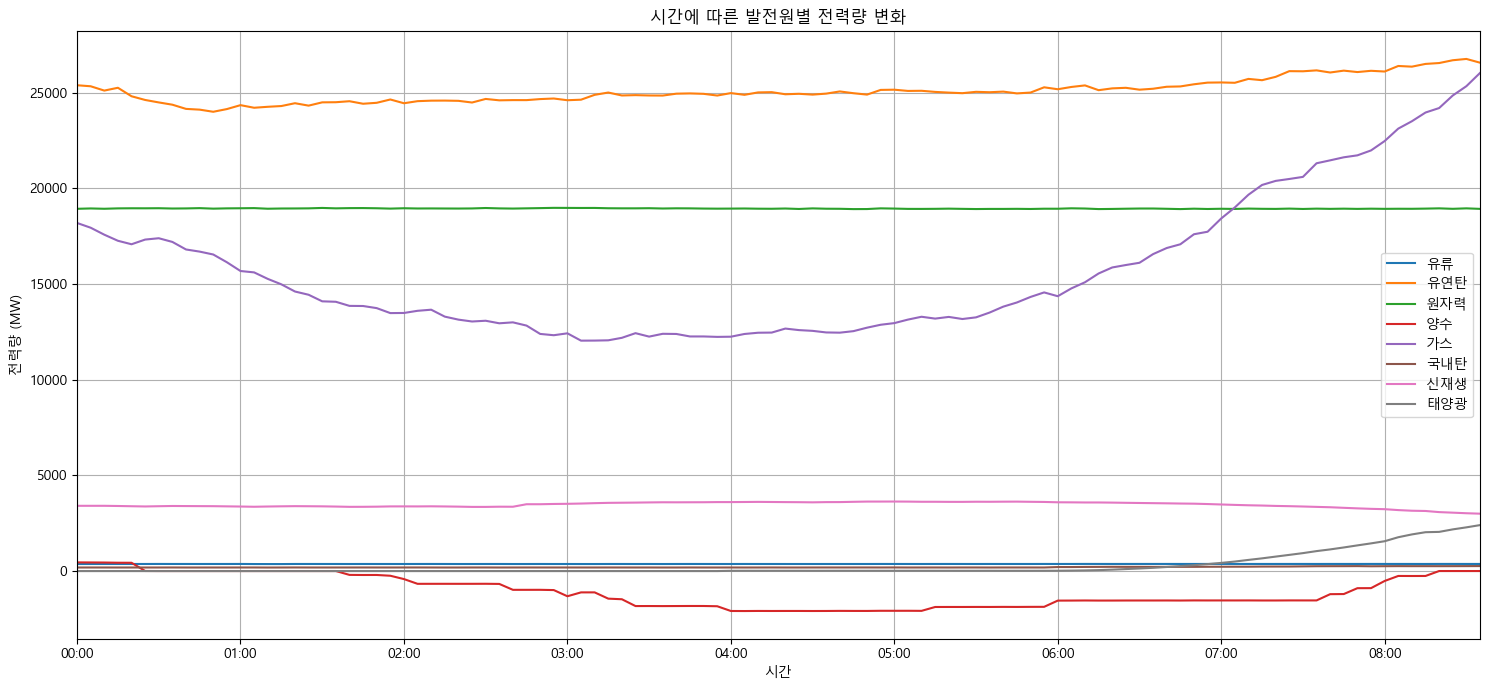

In [11]:

plt.figure(figsize=(15, 7))

for column in df.columns[1:-2]:  # 'baseDatetime','합계','순서'를 제외한 열
    plt.plot(df.index, df[column], label=column)

# X축 레이블 간소화
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # 한 시간마다 간격으로 표시
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# X축 범위 설정
plt.xlim(df.index.min(), df.index.max())

plt.xlabel('시간')
plt.ylabel('전력량 (MW)')
plt.title('시간에 따른 발전원별 전력량 변화')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
print(len(df))

288


### 파이차트_3초단위 애니메이션 파이참에서는 실행가능하나, 판다스에서는 안됨.

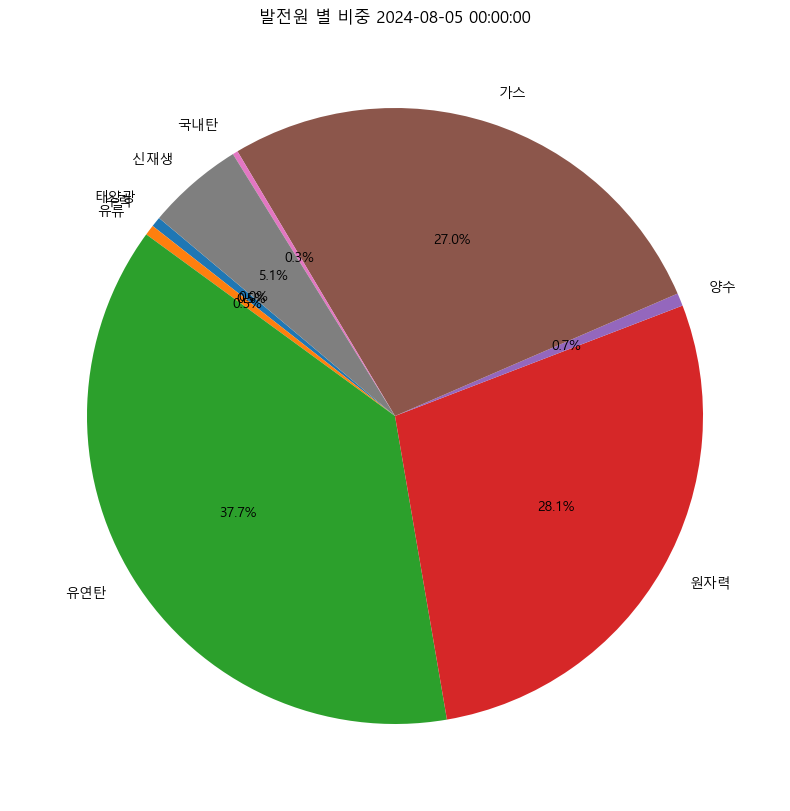

In [21]:
def calculate_proportions(row):
    total = row['합계']
    return {col: row[col] / total * 100 for col in df.columns if col != 'baseDatetime' and col != '합계' and col !='순서'}



def update(frame):

    proportions = df.apply(calculate_proportions, axis=1)
    proportions_df = pd.DataFrame(list(proportions))
    proportions_df.index = df.index
    
    ax.clear()
    ax.pie(
        proportions_df.iloc[frame], 
        labels=proportions_df.columns, 
        autopct='%1.1f%%', 
        startangle=140
    )
    ax.set_title(f'발전원 별 비중 {df["baseDatetime"].iloc[frame]}')


fig, ax = plt.subplots(figsize=(10,10))


ani = FuncAnimation(
    fig, 
    update, 
    frames=len(df), 
    interval=3000  # 3초마다 업데이트
)
# 3:10 에 종료되는 현상이 있는데, 이는 양수가 0 이하의 음수이기 때문이다. 양수는 그 특성상 음수인 기간이 있을 수밖에 없기 때문에, 추후 다른 방법으로
# 비율을 계산하고자 한다.


# 4. 탐색적연구

#### Step1] 가설: 데이터 분석을 위한 목적, 대상 또는 가설을 세워본다.

In [ ]:
정보] 시간별 그래프를 보니, 변동폭이 큰 종류는 가스, 양수, 태양광이었다. 그리고 나머지 원자력, 유연탄, 신재생 등은 일정 범위에서 비슷한 전력생산량을 보였다.
정보] 비중이 제일 큰 3 종류는 원자력, 유연탄, 가스 였다. 그 중에서 원자력과 유연탄은 고정적인 생산량을, 가스는 유동적인 생산량을 보였다.

    가설 1. 가스와 양수는 변동폭이 크기 때문에 전력 수요 등에 영향을 받을 것이다. 예를 들면, 전력 수요가 증가하는 시간대나 요일 등에 더 큰 생산량을 보일 것이다.
    가설 1의 검증 과정에서 얻은 새로운 정보: 전력 공급량은 수요량에 비해 항상 많았다. 대략 30000MW가 남았다. 이 전력이 양수에 전부 쓰이는 게 아닌 것 같다. 
    

* 양수를 찾아보니 양수는 잉여전력으로 물을 댐으로 끌어올려 전력수요가 증가할 때 물을 하강시켜 전력을 생산하는 방법이다.
* , 태양광은 태양이 떠 있는 시간에만 전력생산이 가능하다.
->태양광 발전량과 태양의 일조 시간 사이의 관계를 분석하여 태양

#### Step2] 가설증명: 데이터 재 구조화, 시각화를 통해 새로운 insight 및 정보를 습득 및 가설을 검증한다. 
* 예) 나이별 월급에 대한 평균값을 구하고 line차트로 시각화하여 추세를 파악하여 가설을 검증한다.

가설 1의 검증 : 이를 검증하기 위해 오늘의 전력수요 API를 신청해 검증 중. 
                다른 방법으로, 양수가 전력수요에 따라 생산량이 변화한다는 정보를 찾음.

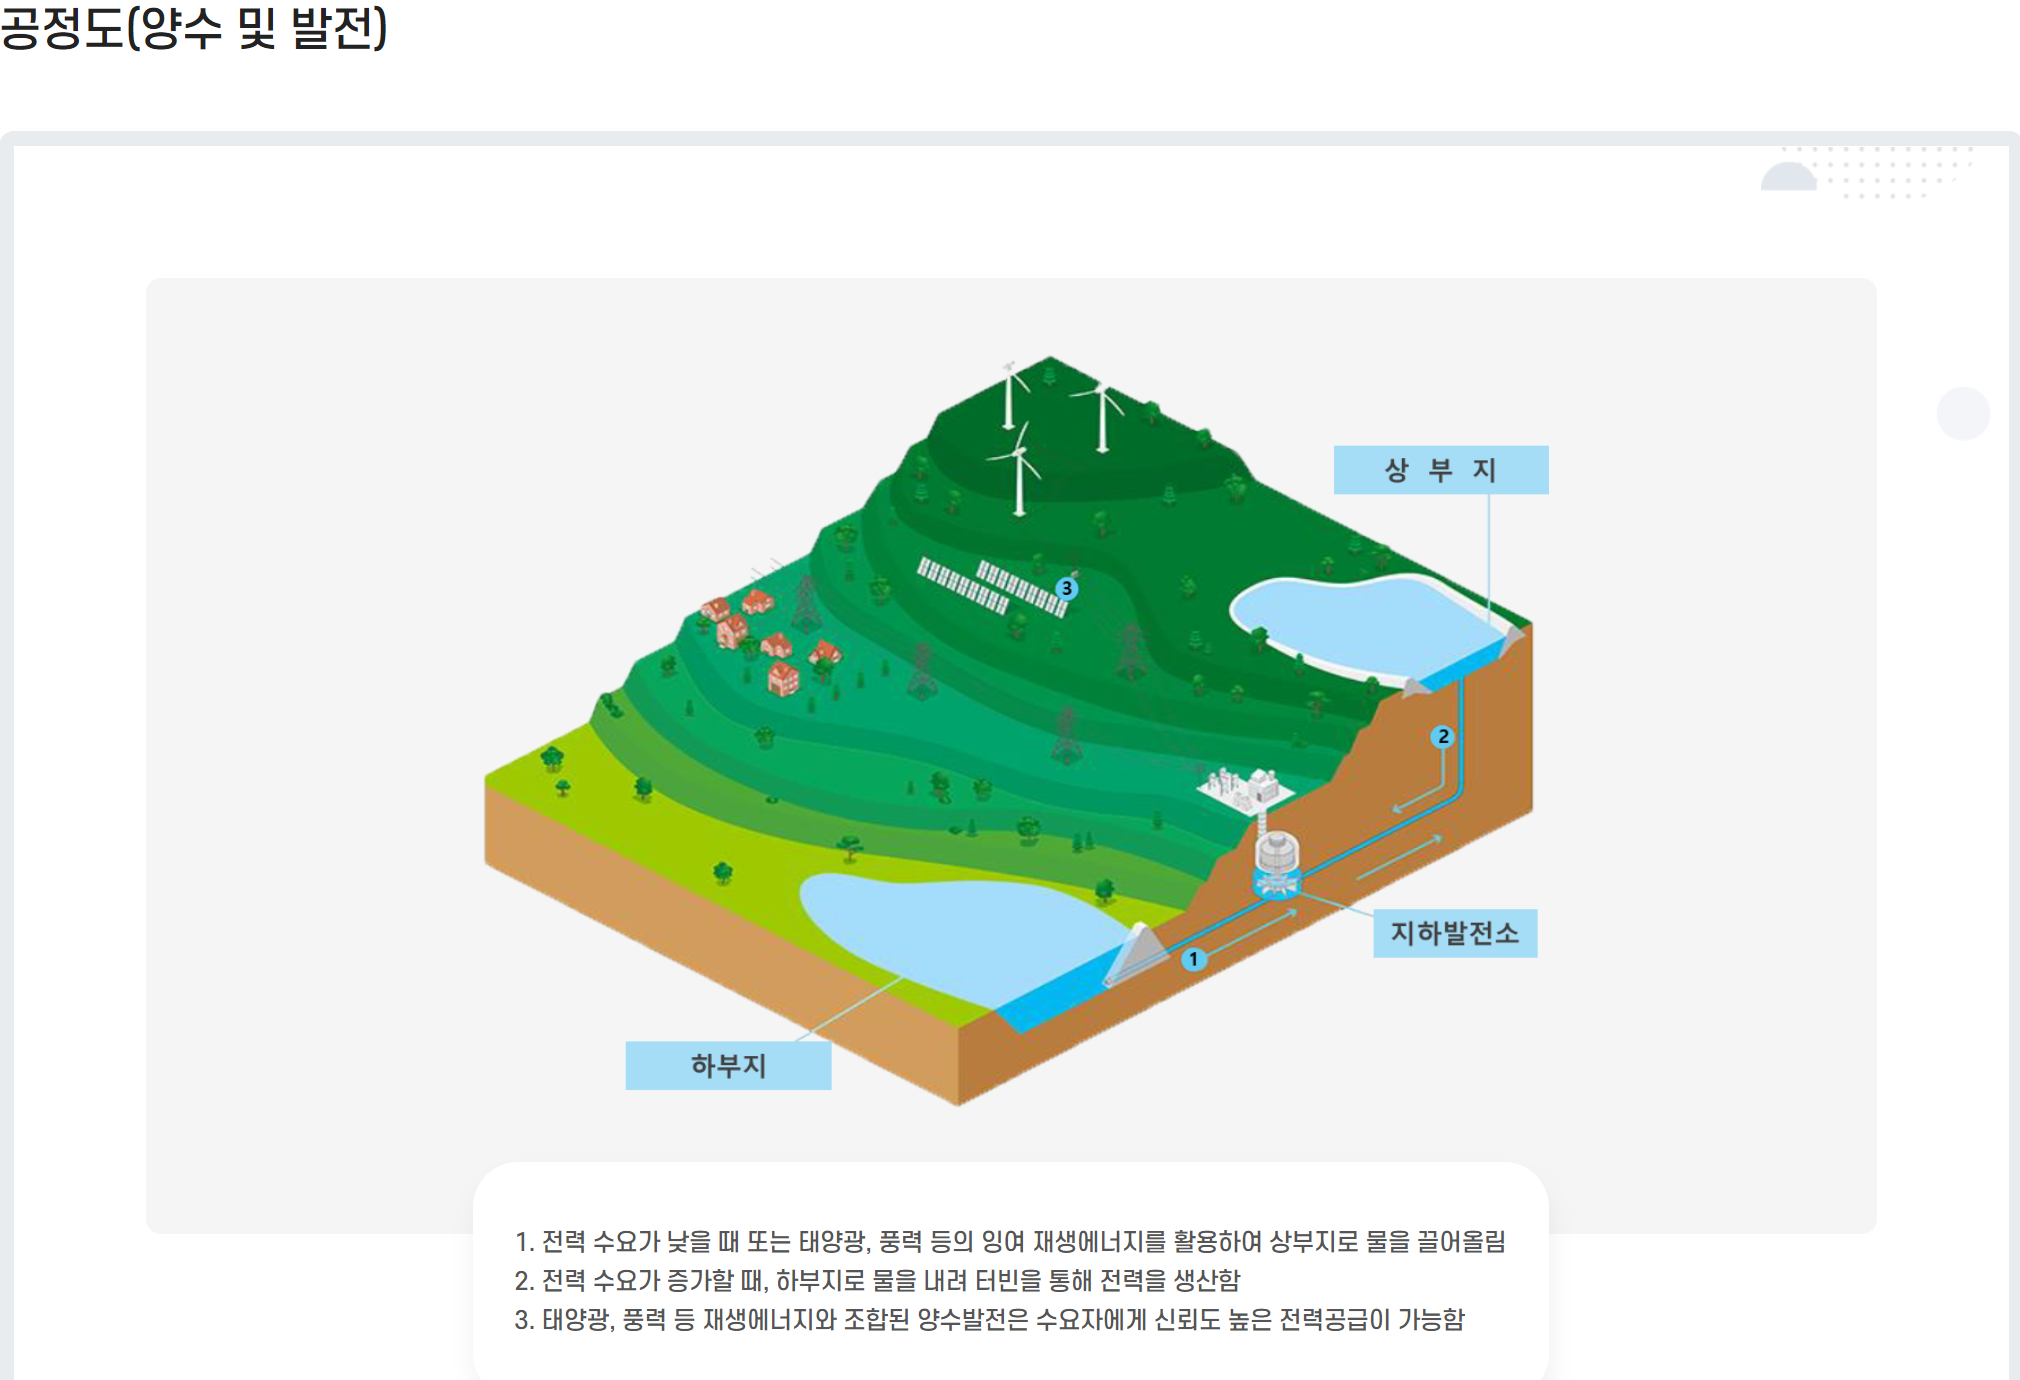

#### Step3] 가설결론: 해당 가설에 대한 결론을 내린다.

#### Step4] 탐색적연구 반복: 시간 일정이 허락하는 범위내에서 Step1~Step3를 반복한다.

#### Step5] 최종결론: 지금까지 진행했던 모든 탐색적연구의 결과를 반영하여 최종 결론을 내린다.